In [31]:
import csv
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [32]:

def read_csv(file_path):
    x_coords_obj1 = []
    y_coords_obj1 = []
    x_coords_obj2 = []
    y_coords_obj2 = []
    frames = []

    with open(file_path, mode="r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header

        for row in reader:
            frame = int(row[0])
            x1, y1 = row[1], row[2]
            x2, y2 = row[3], row[4]

            frames.append(frame)

            if x1 != 'None' and y1 != 'None':
                x_coords_obj1.append(float(x1))
                y_coords_obj1.append(float(y1))

            if x2 != 'None' and y2 != 'None':
                x_coords_obj2.append(float(x2))
                y_coords_obj2.append(float(y2))

    return frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2


In [33]:
def find_circle_center(x_coords, y_coords):
    # Convert coordinates to numpy array for easier manipulation
    x, y = np.array(x_coords), np.array(y_coords)

    # Initial estimate: mean of all points
    initial_center = np.array([np.mean(x), np.mean(y)])

    # Create bins (36 bins between 0 and 2*pi)
    angles = np.arctan2(y - initial_center[1], x - initial_center[0])
    angles = (angles + 2 * np.pi) % (2 * np.pi)  # Normalize angles to [0, 2*pi)

    bins = np.linspace(0, 2 * np.pi, 37)  # 36 bins with 37 edges
    bin_means = []

    # Calculate mean for each bin
    for i in range(len(bins) - 1):
        in_bin = (angles >= bins[i]) & (angles < bins[i + 1])
        if np.any(in_bin):
            bin_points = np.column_stack((x[in_bin], y[in_bin]))
            bin_means.append(np.mean(bin_points, axis=0))

    bin_means = np.array(bin_means)

    # Refine center using new points (bin_means)
    refined_center = np.mean(bin_means, axis=0)

    # Optimize center to minimize variance in distances
    def distance_variance(center):
        distances = np.sqrt((bin_means[:, 0] - center[0]) ** 2 + (bin_means[:, 1] - center[1]) ** 2)
        return np.var(distances)

    result = minimize(distance_variance, refined_center, method='Nelder-Mead')

    return result.x

In [34]:

# Function to calculate angles for both objects
def calculate_angles(frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2, center_obj1, center_obj2):
    angles_obj1 = []
    angles_obj2 = []

    for x1, y1, x2, y2 in zip(x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2):
        # Calculate angle for object 1
        angle1 = np.arctan2(y1 - center_obj1[1], x1 - center_obj1[0])
        angles_obj1.append(angle1)

        # Calculate angle for object 2
        angle2 = np.arctan2(y2 - center_obj2[1], x2 - center_obj2[0])
        angles_obj2.append(angle2)

    return angles_obj1, angles_obj2

# Function to calculate velocities for both objects
# Function to calculate velocities for both objects (absolute value)
def calculate_velocities(frames, angles_obj1, angles_obj2):
    np_angles_obj1 = np.array(angles_obj1[::6])
    np_angles_obj2 = np.array(angles_obj2[::6])
    np_frames = np.array(frames[::6])

    angle_v1 = []
    angle_v2 = []
    angle_forv1 = []
    angle_forv2 = []

    for i in range(len(np_frames) - 1):
        delta_t = np_frames[i + 1] - np_frames[i]
        delta_x1 = (np_angles_obj1[i + 1] - np_angles_obj1[i])
        delta_x2 = (np_angles_obj2[i + 1] - np_angles_obj2[i])

        # Adjust for angular wrapping (ensure continuity)
        if delta_x1 > np.pi:
            delta_x1 -= 2 * np.pi
        elif delta_x1 < -np.pi:
            delta_x1 += 2 * np.pi

        if delta_x2 > np.pi:
            delta_x2 -= 2 * np.pi
        elif delta_x2 < -np.pi:
            delta_x2 += 2 * np.pi

        # Calculate angular velocities
        v1 = delta_x1 / delta_t
        v2 = delta_x2 / delta_t

        # Append absolute velocities
        angle_v1.append(np.abs(v1))
        angle_v2.append(np.abs(v2))
        angle_forv1.append(np_angles_obj1[i])
        angle_forv2.append(np_angles_obj2[i])

    # Convert to NumPy arrays for easier processing
    angle_v1 = np.array(angle_v1)
    angle_v2 = np.array(angle_v2)

    # Dynamically detect and remove outliers using IQR (Interquartile Range)
    def filter_outliers(data):
        q1 = np.percentile(data, 25)
        q3 = np.percentile(data, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return np.where((data < lower_bound) | (data > upper_bound), np.nan, data)

    # Apply outlier filtering
    angle_v1 = filter_outliers(angle_v1)
    angle_v2 = filter_outliers(angle_v2)

    # Remove NaN entries for consistent plotting
    valid_idx1 = ~np.isnan(angle_v1)
    valid_idx2 = ~np.isnan(angle_v2)
    angle_v1 = angle_v1[valid_idx1]
    angle_v2 = angle_v2[valid_idx2]
    angle_forv1 = np.array(angle_forv1)[valid_idx1]
    angle_forv2 = np.array(angle_forv2)[valid_idx2]

    return angle_v1, angle_v2, angle_forv1, angle_forv2


In [35]:
def plot_results(frames, angles_obj1, angles_obj2, angle_forv1, angle_v1, angle_forv2, angle_v2, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2):

    interval_size = np.pi / 8
    angle_bins = np.arange(-np.pi, np.pi, interval_size)
    median_velocity1 = []
    median_velocity2 = []
    pct_95_velocity1 = []
    pct_95_velocity2 = []
    std_err_median1 = []
    std_err_median2 = []
    std_err_pct95_1 = []
    std_err_pct95_2 = []

    for i in range(len(angle_bins) - 1):
        mask1 = (angle_forv1 >= angle_bins[i]) & (angle_forv1 < angle_bins[i + 1])
        if np.any(mask1):
            median_velocity1.append(np.median(angle_v1[mask1]))
            pct_95_velocity1.append(np.percentile(angle_v1[mask1], 95))
            std_err_median1.append(np.std(angle_v1[mask1]) / np.sqrt(np.sum(mask1)))
            std_err_pct95_1.append(np.std(angle_v1[mask1]) / np.sqrt(np.sum(mask1)))
        else:
            median_velocity1.append(None)
            pct_95_velocity1.append(None)
            std_err_median1.append(None)
            std_err_pct95_1.append(None)

        mask2 = (angle_forv2 >= angle_bins[i]) & (angle_forv2 < angle_bins[i + 1])
        if np.any(mask2):
            median_velocity2.append(np.median(angle_v2[mask2]))
            pct_95_velocity2.append(np.percentile(angle_v2[mask2], 95))
            std_err_median2.append(np.std(angle_v2[mask2]) / np.sqrt(np.sum(mask2)))
            std_err_pct95_2.append(np.std(angle_v2[mask2]) / np.sqrt(np.sum(mask2)))
        else:
            median_velocity2.append(None)
            pct_95_velocity2.append(None)
            std_err_median2.append(None)
            std_err_pct95_2.append(None)

    fig, axs = plt.subplots(5, 1, figsize=(8, 30))

    # Plot 1: Phase space for Object 1 with median, 95th percentile, and std error
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2
    axs[0].scatter(angle_forv1, angle_v1, label="Phase Space Obj 1", color="blue")
    axs[0].plot(bin_centers, median_velocity1, label="Median Velocity", color="red", marker='o')
    axs[0].errorbar(bin_centers, median_velocity1, yerr=std_err_median1, fmt='o', color="red", label="Std Error (Median)")
    axs[0].plot(bin_centers, pct_95_velocity1, label="95th Percentile", color="purple", linestyle='--')
    axs[0].errorbar(bin_centers, pct_95_velocity1, yerr=std_err_pct95_1, fmt='o', color="purple", label="Std Error (95th Percentile)")
    axs[0].set_xlabel("Angle (radians)")
    axs[0].set_ylabel("Angular Velocity")
    axs[0].set_title("Phase Space for Object 1 with Statistics")
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2: Phase space for Object 2 with median, 95th percentile, and std error
    axs[1].scatter(angle_forv2, angle_v2, label="Phase Space Obj 2", color="green")
    axs[1].plot(bin_centers, median_velocity2, label="Median Velocity", color="red", marker='o')
    axs[1].errorbar(bin_centers, median_velocity2, yerr=std_err_median2, fmt='o', color="red", label="Std Error (Median)")
    axs[1].plot(bin_centers, pct_95_velocity2, label="95th Percentile", color="purple", linestyle='--')
    axs[1].errorbar(bin_centers, pct_95_velocity2, yerr=std_err_pct95_2, fmt='o', color="purple", label="Std Error (95th Percentile)")
    axs[1].set_xlabel("Angle (radians)")
    axs[1].set_ylabel("Angular Velocity")
    axs[1].set_title("Phase Space for Object 2 with Statistics")
    axs[1].legend()
    axs[1].grid(True)

    # Plot 3: Boxplot for Object 1
    box_data1 = [angle_v1[(angle_forv1 >= angle_bins[i]) & (angle_forv1 < angle_bins[i + 1])] for i in range(len(angle_bins) - 1)]
    axs[2].boxplot(box_data1, positions=bin_centers, widths=0.1, patch_artist=True, boxprops=dict(facecolor="blue"))
    axs[2].set_xlabel("Angle (radians)")
    axs[2].set_ylabel("Velocity")
    axs[2].set_title("Boxplot of Velocities for Object 1")
    axs[2].grid(True)
    axs[2].tick_params(axis='x', rotation=45)
    axs[2].set_xticks(bin_centers)
    axs[2].set_xticklabels([f"{x:.2f}" for x in bin_centers])

    # Plot 4: Boxplot for Object 2
    box_data2 = [angle_v2[(angle_forv2 >= angle_bins[i]) & (angle_forv2 < angle_bins[i + 1])] for i in range(len(angle_bins) - 1)]
    axs[3].boxplot(box_data2, positions=bin_centers, widths=0.1, patch_artist=True, boxprops=dict(facecolor="blue"))
    axs[3].set_xlabel("Angle (radians)")
    axs[3].set_ylabel("Velocity")
    axs[3].set_title("Boxplot of Velocities for Object 2")
    axs[3].grid(True)
    axs[3].tick_params(axis='x', rotation=45)
    axs[3].set_xticks(bin_centers)
    axs[3].set_xticklabels([f"{x:.2f}" for x in bin_centers])

    # Plot 5: Angles of Objects vs Time
    time_minutes = np.array(frames) / 60
    axs[4].plot(time_minutes, angles_obj1, label="Angle Obj 1", color="blue")
    axs[4].plot(time_minutes, angles_obj2, label="Angle Obj 2", color="green")
    axs[4].set_xlabel("Time (minutes)")
    axs[4].set_ylabel("Angle (radians)")
    axs[4].set_title("Angles of Objects Over Time")
    axs[4].legend()
    axs[4].grid(True)

    plt.tight_layout()
    plt.show()


Calculated center for Object 1: [966.44883071 436.4421283 ]
Calculated center for Object 2: [930.36257128 417.73801645]
Phase-space data for Object 1 saved to: C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024_09_23\phase_space_data_obj1.csv
Phase-space data for Object 2 saved to: C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024_09_23\phase_space_data_obj2.csv


TypeError: bad operand type for unary -: 'NoneType'

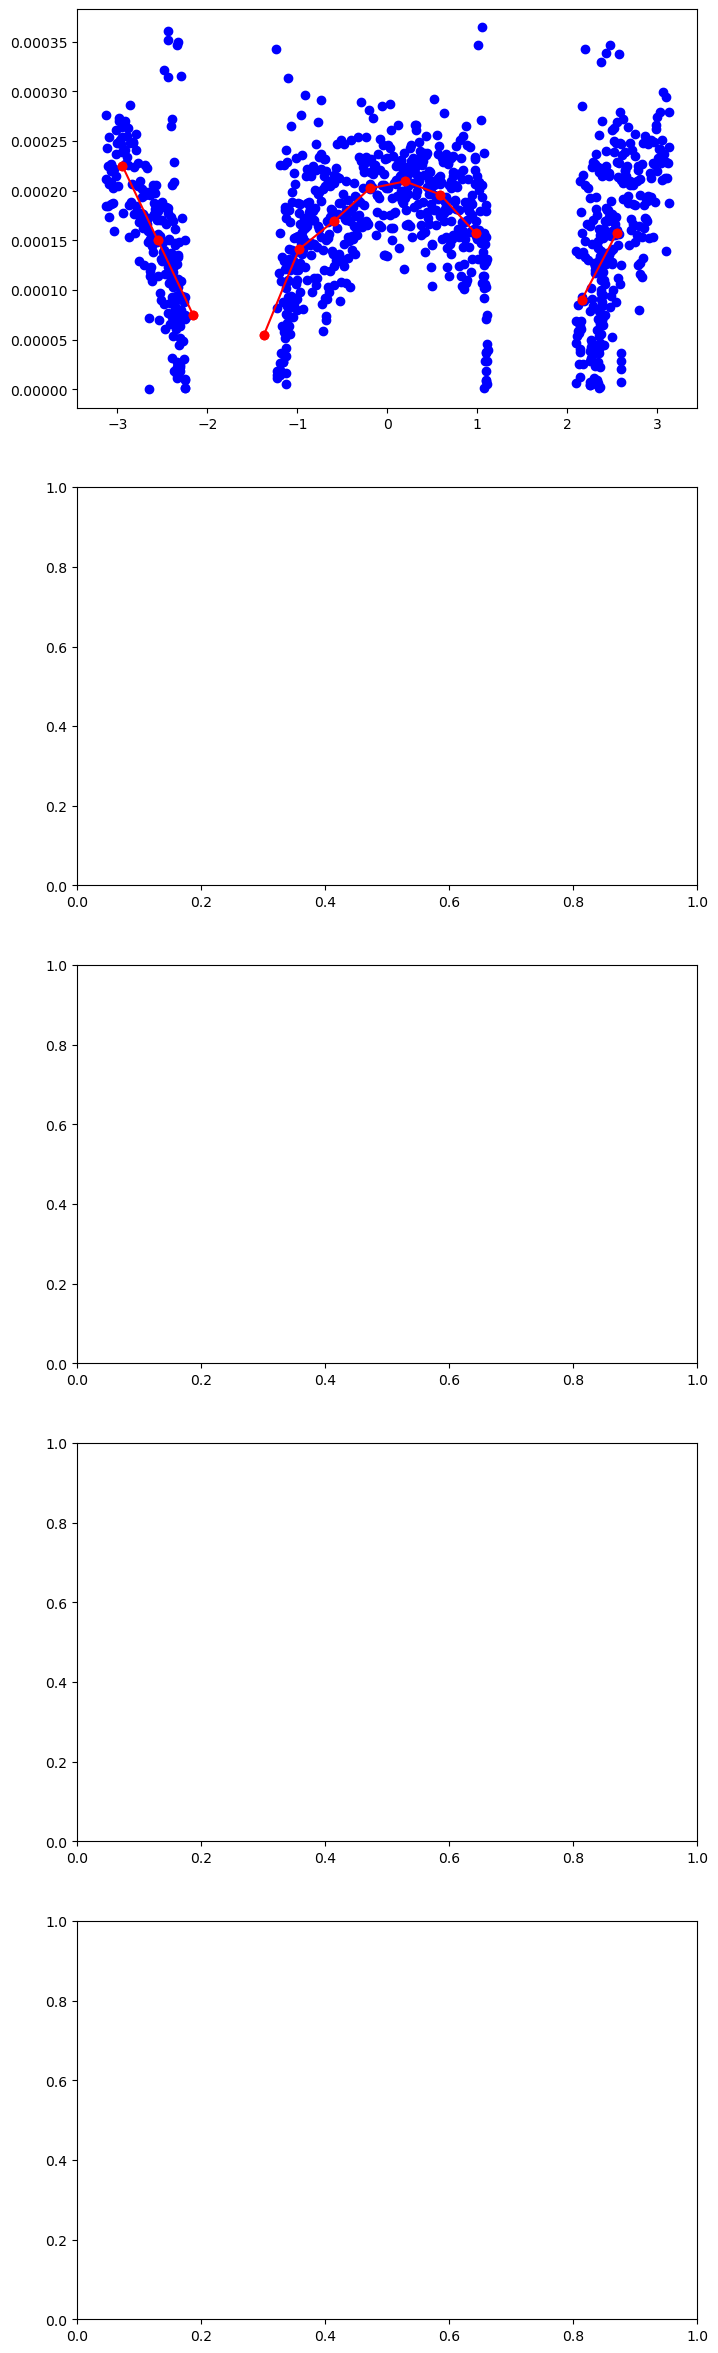

In [38]:
folder_path = R"C:\Users\barei\Documents\GitHub\Ants\Analyzed Data\2024_09_23"
file_path = os.path.join(folder_path, "coordinates.csv")

frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2 = read_csv(file_path)

# Calculate centers
center_obj1 = find_circle_center(x_coords_obj1, y_coords_obj1)
center_obj2 = find_circle_center(x_coords_obj2, y_coords_obj2)
print(f"Calculated center for Object 1: {center_obj1}")
print(f"Calculated center for Object 2: {center_obj2}")

# Calculate angles
angles_obj1, angles_obj2 = calculate_angles(frames, x_coords_obj1, y_coords_obj1, x_coords_obj2, y_coords_obj2, center_obj1, center_obj2)

# Calculate velocities
angle_v1, angle_v2, angle_forv1, angle_forv2 = calculate_velocities(frames, angles_obj1, angles_obj2)

# Save phase-space data for Object 1
phase_space_data_obj1 = pd.DataFrame({
    "Angle": angle_forv1,
    "Angular Velocity": angle_v1
})
output_file_obj1 = os.path.join(folder_path, "phase_space_data_obj1.csv")
phase_space_data_obj1.to_csv(output_file_obj1, index=False)

# Save phase-space data for Object 2
phase_space_data_obj2 = pd.DataFrame({
    "Angle": angle_forv2,
    "Angular Velocity": angle_v2
})
output_file_obj2 = os.path.join(folder_path, "phase_space_data_obj2.csv")
phase_space_data_obj2.to_csv(output_file_obj2, index=False)

print(f"Phase-space data for Object 1 saved to: {output_file_obj1}")
print(f"Phase-space data for Object 2 saved to: {output_file_obj2}")

# Plot results
plot_results(
    frames, angles_obj1, angles_obj2,
    angle_forv1, angle_v1,
    angle_forv2, angle_v2,
    x_coords_obj1, y_coords_obj1,
    x_coords_obj2, y_coords_obj2
)
